In [8]:
# PPO LunarLander-v3 Evaluation

# This notebook loads the trained PPO model from checkpoints and evaluates it on LunarLander-v3 for 100 episodes.

## Import Libraries

In [9]:
import torch
import torch.nn as nn
import numpy as np
import gymnasium as gym
from torch.distributions.categorical import Categorical
import matplotlib.pyplot as plt
import os

## Define Agent Architecture

Recreate the Agent class to match the trained model structure.

In [10]:
def layer_init(layer, std=np.sqrt(2), bias_const=0.0):
    torch.nn.init.orthogonal_(layer.weight, std)
    torch.nn.init.constant_(layer.bias, bias_const)
    return layer


class Agent(nn.Module):
    def __init__(self, envs):
        super().__init__()
        input_shape = np.array(envs.single_observation_space.shape).prod()
        action_shape = envs.single_action_space.n

        self.critic = nn.Sequential(
            layer_init(nn.Linear(input_shape, 64)),
            nn.Tanh(),
            layer_init(nn.Linear(64, 64)),
            nn.Tanh(),
            layer_init(nn.Linear(64, 1), std=1.0)
        )

        self.actor = nn.Sequential(
            layer_init(nn.Linear(input_shape, 64)),
            nn.Tanh(),
            layer_init(nn.Linear(64, 64)),
            nn.Tanh(),
            layer_init(nn.Linear(64, action_shape), std=1.0)
        )

    def get_critic_value(self, x):
        return self.critic(x)

    def get_actor_values(self, x, action=None):
        logits = self.actor(x)
        probs = Categorical(logits=logits)
        if action is None:
            action = probs.sample()
        return action, probs.log_prob(action), probs.entropy()
    
    def get_action(self, x):
        """Get action for evaluation (deterministic)"""
        logits = self.actor(x)
        probs = Categorical(logits=logits)
        action = probs.sample()  # For stochastic, or use argmax for deterministic
        return action

## Setup Environment and Load Model

In [11]:
# Setup device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Create environment
env_name = "LunarLander-v3"
num_envs = 1
envs = gym.make_vec(env_name, num_envs=num_envs, vectorization_mode="sync")

# Create agent
agent = Agent(envs).to(device)

# Load the trained model
checkpoint_path = "./ppo_lunar_lander_checkpoints/!final_model.pth"
if os.path.exists(checkpoint_path):
    agent.load_state_dict(torch.load(checkpoint_path, map_location=device))
    print(f"Model loaded successfully from {checkpoint_path}")
else:
    print(f"ERROR: Model file not found at {checkpoint_path}")
    
agent.eval()  # Set to evaluation mode

Using device: cpu
Model loaded successfully from ./checkpoints/!final_model.pth


Agent(
  (critic): Sequential(
    (0): Linear(in_features=8, out_features=64, bias=True)
    (1): Tanh()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): Tanh()
    (4): Linear(in_features=64, out_features=1, bias=True)
  )
  (actor): Sequential(
    (0): Linear(in_features=8, out_features=64, bias=True)
    (1): Tanh()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): Tanh()
    (4): Linear(in_features=64, out_features=4, bias=True)
  )
)

## Run Evaluation for 100 Episodes

In [12]:
num_eval_episodes = 100
eval_rewards = []
eval_episode_lengths = []

print(f"Running {num_eval_episodes} evaluation episodes...")
print("="*60)

for episode in range(num_eval_episodes):
    obs, _ = envs.reset()
    obs = torch.Tensor(obs).to(device)
    done = False
    episode_reward = 0
    episode_length = 0
    
    while not done:
        with torch.no_grad():
            action, _, _ = agent.get_actor_values(obs)
        
        next_obs, reward, terminations, truncations, _ = envs.step(action.cpu().numpy())
        done = terminations[0] or truncations[0]
        
        obs = torch.Tensor(next_obs).to(device)
        episode_reward += reward[0]
        episode_length += 1
    
    eval_rewards.append(episode_reward)
    eval_episode_lengths.append(episode_length)
    
    #if (episode + 1) % 10 == 0:
    print(f"Episode {episode + 1}/{num_eval_episodes} | Reward: {episode_reward:.2f}")

print("="*60)
print("Evaluation complete!")

Running 100 evaluation episodes...
Episode 1/100 | Reward: 297.24
Episode 1/100 | Reward: 297.24
Episode 2/100 | Reward: 323.13
Episode 2/100 | Reward: 323.13
Episode 3/100 | Reward: 313.59
Episode 3/100 | Reward: 313.59
Episode 4/100 | Reward: 256.13
Episode 5/100 | Reward: 303.55
Episode 4/100 | Reward: 256.13
Episode 5/100 | Reward: 303.55
Episode 6/100 | Reward: 281.09
Episode 6/100 | Reward: 281.09
Episode 7/100 | Reward: 283.55
Episode 7/100 | Reward: 283.55
Episode 8/100 | Reward: 310.54
Episode 8/100 | Reward: 310.54
Episode 9/100 | Reward: 297.95
Episode 9/100 | Reward: 297.95
Episode 10/100 | Reward: 280.72
Episode 10/100 | Reward: 280.72
Episode 11/100 | Reward: 267.44
Episode 11/100 | Reward: 267.44
Episode 12/100 | Reward: 303.46
Episode 12/100 | Reward: 303.46
Episode 13/100 | Reward: 287.14
Episode 13/100 | Reward: 287.14
Episode 14/100 | Reward: 289.56
Episode 14/100 | Reward: 289.56
Episode 15/100 | Reward: 280.22
Episode 16/100 | Reward: 66.43
Episode 15/100 | Reward:

## Results Summary

In [13]:
# Calculate statistics
mean_reward = np.mean(eval_rewards)
std_reward = np.std(eval_rewards)
min_reward = np.min(eval_rewards)
max_reward = np.max(eval_rewards)
median_reward = np.median(eval_rewards)

mean_length = np.mean(eval_episode_lengths)
std_length = np.std(eval_episode_lengths)

print("\n" + "="*60)
print("EVALUATION RESULTS")
print("="*60)
print(f"Number of episodes: {num_eval_episodes}")
print(f"\nReward Statistics:")
print(f"  Mean:   {mean_reward:.2f} ± {std_reward:.2f}")
print(f"  Median: {median_reward:.2f}")
print(f"  Min:    {min_reward:.2f}")
print(f"  Max:    {max_reward:.2f}")
print(f"\nEpisode Length:")
print(f"  Mean:   {mean_length:.2f} ± {std_length:.2f}")
print("="*60)


EVALUATION RESULTS
Number of episodes: 100

Reward Statistics:
  Mean:   263.34 ± 65.50
  Median: 281.20
  Min:    -18.12
  Max:    326.34

Episode Length:
  Mean:   215.48 ± 140.41


## Visualize Results

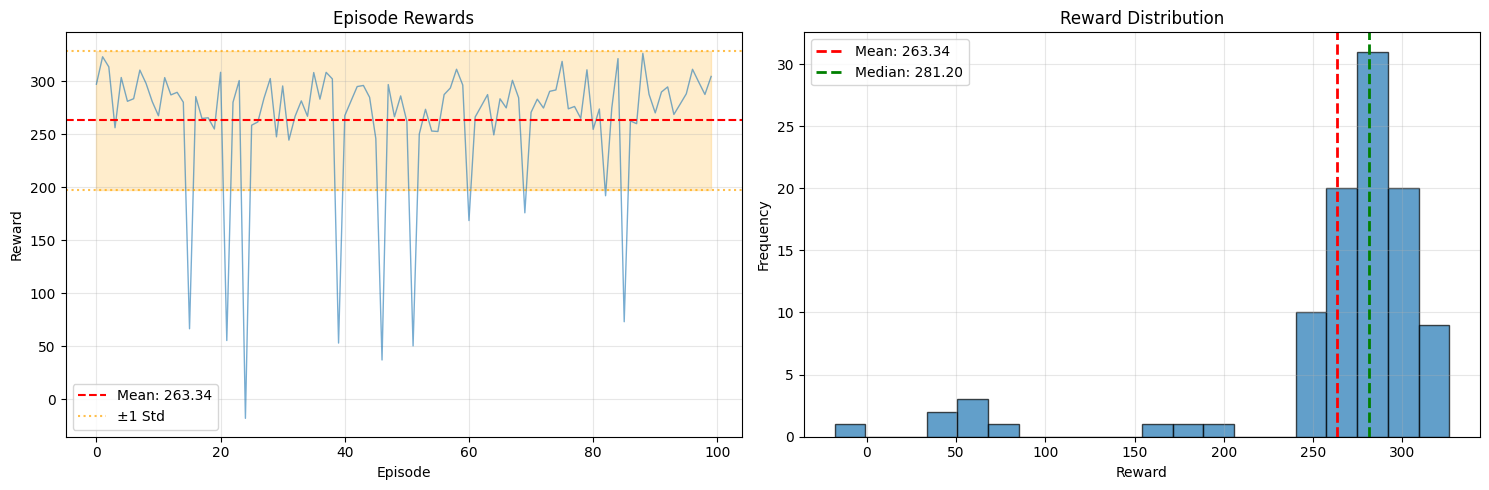


Success rate (reward > 200): 90.0%


In [14]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Reward per episode
axes[0].plot(eval_rewards, alpha=0.6, linewidth=1)
axes[0].axhline(y=mean_reward, color='r', linestyle='--', label=f'Mean: {mean_reward:.2f}')
axes[0].axhline(y=mean_reward + std_reward, color='orange', linestyle=':', alpha=0.7, label=f'±1 Std')
axes[0].axhline(y=mean_reward - std_reward, color='orange', linestyle=':', alpha=0.7)
axes[0].fill_between(range(len(eval_rewards)), 
                       mean_reward - std_reward, 
                       mean_reward + std_reward, 
                       alpha=0.2, color='orange')
axes[0].set_xlabel('Episode')
axes[0].set_ylabel('Reward')
axes[0].set_title('Episode Rewards')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Reward distribution
axes[1].hist(eval_rewards, bins=20, edgecolor='black', alpha=0.7)
axes[1].axvline(x=mean_reward, color='r', linestyle='--', linewidth=2, label=f'Mean: {mean_reward:.2f}')
axes[1].axvline(x=median_reward, color='g', linestyle='--', linewidth=2, label=f'Median: {median_reward:.2f}')
axes[1].set_xlabel('Reward')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Reward Distribution')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nSuccess rate (reward > 200): {sum(1 for r in eval_rewards if r > 200) / len(eval_rewards) * 100:.1f}%")

## Watch a Single Episode (Optional)

Uncomment and run this cell to watch the agent play one episode with rendering.